# Generating SMBH/SOBH signals from catalogue - using FD response

Sylvain Marsat | 2017-11-17

## Loading

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, math, time
from scipy.signal import butter, lfilter
from scipy import signal

#sys.path.append(os.path.abspath('../../../../../LDC/software/Waveforms/MBH_IMR/MP/'))
#sys.path.append(os.path.abspath('../../../../../LDC/software/Packages/common/'))
#sys.path.append(os.path.abspath('../../../../../LDC/software/MLDCpipeline/scripts/'))
from pyIMRPhenomD import IMRPhenomD, MSUN_SI, PC_SI
import Cosmology
import LISAConstants as LC
#import ParseWriteXML as pwXML
from LISAhdf5 import LISAhdf5,ParsUnits

In [14]:
from pyFDresponse import *

## Definitions

### Plotting

In [15]:
# Color palette stolen from seaborn package (deep, with reshuffled ordering)
# SEABORN_PALETTES = dict(
#     deep=["#4C72B0", "#55A868", "#C44E52",
#           "#8172B2", "#CCB974", "#64B5CD"],
#     muted=["#4878CF", "#6ACC65", "#D65F5F",
#            "#B47CC7", "#C4AD66", "#77BEDB"],
#     pastel=["#92C6FF", "#97F0AA", "#FF9F9A",
#             "#D0BBFF", "#FFFEA3", "#B0E0E6"],
#     bright=["#003FFF", "#03ED3A", "#E8000B",
#             "#8A2BE2", "#FFC400", "#00D7FF"],
#     dark=["#001C7F", "#017517", "#8C0900",
#           "#7600A1", "#B8860B", "#006374"],
#     colorblind=["#0072B2", "#009E73", "#D55E00",
#                 "#CC79A7", "#F0E442", "#56B4E9"]
#)
palette = ["#4C72B0", "#C44E52", "#CCB974", "#55A868", "#8172B2", "#64B5CD"]

In [16]:
def plot_wf_ampphase(wf):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    f, amp, phase = wf
    ax1.plot(f, amp, color=palette[0])
    ax1.set_xlim(min(f), max(f))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid()
    ax2.plot(f, phase, color=palette[0])
    ax2.set_xlim(min(f), max(f))
    ax2.set_xscale('log')
    ax2.grid()
    plt.show()

In [17]:
def plot_wf_tdi_all(wf, scalebyf2=False):
    fig, ax = plt.subplots(3, 3, figsize=(16,12))
    f, amp, phase, phaseRdelay, transferL1, transferL2, transferL3, TDI1, TDI2, TDI3, TDItag = wf['freq'], wf['amp'], wf['phase'], wf['phaseRdelay'], wf['transferL1'], wf['transferL2'], wf['transferL3'], wf['TDI1'], wf['TDI2'], wf['TDI3'], wf['TDItag']
    # Common settings
    for i in range(3):
        for j in range(3):
            ax[i][j].set_xlim(min(f), max(f))
            ax[i][j].set_xscale('log')
            ax[i][j].set_xlabel(r'f (Hz)')
            ax[i][j].grid()
    # Amp
    ax[0][0].plot(f, amp, color=palette[0])
    ax[0][0].set_yscale('log')
    ax[0][0].set_ylabel(r'$A_{22}$')
    ax[0][0].set_title(r'Amplitude')
    # Phase
    ax[0][1].plot(f, phase, color=palette[0])
    ax[0][1].set_xscale('log')
    ax[0][1].set_ylabel(r'$\Phi_{22}$')
    ax[0][1].set_title(r'Phase')
    # Orbital delay phase
    ax[0][2].plot(f, phaseRdelay, color=palette[0])
    ax[0][2].set_xscale('log')
    ax[0][2].axhline(0, color='k')
    ax[0][2].set_ylabel(r'$\Phi_{d_0}$')
    ax[0][2].set_title(r'Orbital delay phase')
    # TDI and transfer
    transL = {}
    if scalebyf2:
        fstar = C_SI/L_SI
        transL[1], transL[2], transL[3] = transferL1*(fstar/f)**2, transferL2*(fstar/f)**2, transferL3*(fstar/f)**2
    else:
        transL[1], transL[2], transL[3] = transferL1, transferL2, transferL3
    tdi = {}
    tdi[1], tdi[2], tdi[3] = TDI1, TDI2, TDI3
    # Labels
    tdilabel = {}
    if TDItag=='TDIXYZ':
        tdilabel[1] = 'X'
        tdilabel[2] = 'Y'
        tdilabel[3] = 'Z'
    elif TDItag=='TDIAET':
        tdilabel[1] = 'A'
        tdilabel[2] = 'E'
        tdilabel[3] = 'T'
    else:
        raise ValueError("Error in plot_wf_tdi: TDItag not recognized.")
    ylabeltrans = {}; titletrans = {}; ylabeltdi = {}; titletdi = {};
    for i in range(1,4):
        if scalebyf2:
            ylabeltrans[i] = r'$(f_{*}/f)^2\mathcal{T}^L_'+tdilabel[i]+'$'
        else:
            ylabeltrans[i] = r'$\mathcal{T}^L_'+tdilabel[i]+'$'
        titletrans[i] = r'Transfer '+tdilabel[i]+' Re/Im'
        ylabeltdi[i] = r'$\mathrm{TDI}_'+tdilabel[i]+'$'
        titletdi[i] = r'TDI '+tdilabel[i]+' Re/Im'
    # Plot transfer
    for i in range(1,4):
        ax[1][i-1].plot(f, np.real(transL[i]), color=palette[0])
        ax[1][i-1].plot(f, np.imag(transL[i]), color=palette[1])
        ax[1][i-1].axhline(0, color='k')
        ax[1][i-1].set_ylabel(ylabeltrans[i])
        ax[1][i-1].set_title(titletrans[i])
    # Plot TDI
    for i in range(1,4):
        ax[2][i-1].plot(f, np.real(tdi[i]), color=palette[0])
        ax[2][i-1].plot(f, np.imag(tdi[i]), color=palette[1])
        ax[2][i-1].axhline(0, color='k')
        ax[2][i-1].set_ylabel(ylabeltdi[i])
        ax[2][i-1].set_title(titletdi[i])
    plt.tight_layout()
    plt.show()

In [18]:
# Restrict data to an interval according to first column
def restrict_data(data, interval):
    if not interval: # test if interval==[]
        return data
    else:
        # Make an initial guess based on global length - then adjust starting and ending indices
        x = data[:,0]
        n = len(data)
        deltax = (x[-1] - x[0]) / n
        if interval[0] < x[0]:
            ibeg = 0
        else:
            ibeg = min(int((interval[0]-x[0]) / deltax), n-1)
            while ibeg < n and x[ibeg] < interval[0]:
                ibeg += 1
            while ibeg > 0 and x[ibeg-1] > interval[0]:
                ibeg -= 1
        if interval[-1] > x[-1]:
            iend = n-1
        else:
            iend = n-1 - min(int((x[-1] - interval[-1]) / deltax), n-1)
            while iend > 0 and x[iend] > interval[-1]:
                iend -= 1
            while iend < n-1 and x[iend+1] < interval[-1]:
                iend += 1
        return data[ibeg:iend+1]
# Fold a list : get n elements by cycling through the list
def fold_list(xlist, n):
    l = len(xlist)
    return (xlist * (n/l + 1))[:n]

In [19]:
# Color palette stolen from seaborn package (deep, with reshuffled ordering)
# SEABORN_PALETTES = dict(
#     deep=["#4C72B0", "#55A868", "#C44E52",
#           "#8172B2", "#CCB974", "#64B5CD"],
#     muted=["#4878CF", "#6ACC65", "#D65F5F",
#            "#B47CC7", "#C4AD66", "#77BEDB"],
#     pastel=["#92C6FF", "#97F0AA", "#FF9F9A",
#             "#D0BBFF", "#FFFEA3", "#B0E0E6"],
#     bright=["#003FFF", "#03ED3A", "#E8000B",
#             "#8A2BE2", "#FFC400", "#00D7FF"],
#     dark=["#001C7F", "#017517", "#8C0900",
#           "#7600A1", "#B8860B", "#006374"],
#     colorblind=["#0072B2", "#009E73", "#D55E00",
#                 "#CC79A7", "#F0E442", "#56B4E9"]
#)
palette = ["#4C72B0", "#C44E52", "#CCB974", "#55A868", "#8172B2", "#64B5CD"]
def lplot(ax, *args, **kwargs):
    rangex = kwargs.get('rangex', [])
    rangey = kwargs.get('rangey', [])
    ds = kwargs.get('downsample', 1)
    size = kwargs.get('figsize', (8, 4))
    grid = kwargs.get('grid', True)
    colormap = kwargs.get('colormap', None)
    colormapbounds = kwargs.get('colormapbounds', [0.,1.])
    colors = kwargs.get('colors', None)
    linestyles = kwargs.get('linestyles', None)
    log_xscale = kwargs.get('log_xscale', False)
    log_yscale = kwargs.get('log_yscale', False)
    n = len(args)
    if colors is None: # colors option supersedes colormap
        if colormap is not None:
            colorm = cm.get_cmap(colormap)
            colors = [colorm(x) for x in np.linspace(colormapbounds[0], colormapbounds[1], n)]
        else:
            #defaultcolorlist = plt.rcParams['axes.prop_cycle'].by_key()['color']
            defaultcolorlist = palette
            colors = fold_list(defaultcolorlist, n)
    if linestyles is None:
        linestyles = ['-' for i in range(n)]
    f = plt.figure(0, figsize=size)
    minxvals = np.zeros(n)
    maxxvals = np.zeros(n)
    minyvals = np.zeros(n)
    maxyvals = np.zeros(n)
    avyvals = np.zeros(n)
    for i, x in enumerate(args):
        if type(x[1]) is np.ndarray:
            data = restrict_data(np.array([x[0][::ds], x[1][::ds]]).T, rangex)
            col1, col2 = [0, 1]
        else:
            data = restrict_data(x[0][::ds], rangex)
            col1, col2 = x[1]
        if not log_xscale:
            minxvals[i] = data[0, col1]
        else: # Restrict to the first non-zero value of y - convenient for log-x plots (also always exclude x=0)
            datax = data[:, col1]
            datay = data[:, col2]
            if datax[0]==0.:
                datax = datax[1:]
                datay = datay[1:]
            minxvals[i] = datax[(datay > 0)][0]
        maxxvals[i] = data[-1, col1]
        minyvals[i] = min(data[:, col2])
        maxyvals[i] = max(data[:, col2])
        avyvals[i] = np.average(data[:, col2])
        ax.plot(data[:,col1], data[:,col2], color=colors[i], linestyle=linestyles[i])
    if rangex:
        ax.set_xlim(rangex[0], rangex[1])
    else:
        ax.set_xlim(min(minxvals), max(maxxvals))
    if rangey:
        ax.set_ylim(rangey[0], rangey[1])
    else:
        if log_yscale:
            minyvalplot = max(min(minyvals), 1e-8*np.average(avyvals))
            ax.set_ylim(1./1.5*minyvalplot, 1.5*max(maxyvals))
        else:
            margin = 0.1 * (max(maxyvals) - np.average(avyvals))
            ax.set_ylim(min(minyvals) - margin, max(maxyvals) + margin)
    if log_xscale:
        ax.set_xscale('log')
    if log_yscale:
        ax.set_yscale('log')
    if grid:
        ax.grid()
        
def llogplot(ax, *arg, **kwargs):
    args = (ax,) + arg
    return lplot(*args, log_yscale=True, **kwargs)
def lloglinearplot(ax, *arg, **kwargs):
    args = (ax,) + arg
    return lplot(*args, log_xscale=True, **kwargs)
def lloglogplot(ax, *arg, **kwargs):
    args = (ax,) + arg
    return lplot(*args, log_xscale=True, log_yscale=True, **kwargs)

## SMBH

### Reading catalogue file and selecting sources

In [13]:
##### 1. Reading the catalogue file ####
catDir = "../../../../../Catalogues/MBHs/"
catName = "catalog_Q3_delay_real106.out"

data = np.genfromtxt(catDir+catName)
print np.shape(data)

zs = data[:, 0]
m1s = data[:, 1]
m2s = data[:, 2]

chi1s = data[:, 3]
chi2s = data[:, 4]
Stheta1s = data[:, 5]
Stheta2s = data[:, 6]
Sphi12s = data[:, 7]

Tcs = data[:, 8]

SkyThs = data[:, 9]
SkyPhs = data[:, 10]

Inkls = data[:, 11]

Mtot = (m1s+m2s)*(1.0+zs)
qs = m1s/m2s

(52, 15)


In [14]:
########### 2. Choosing the source based on our criteria  #########
inds = []
for i in xrange(len(m1s)):
    if ((Tcs[i] > 0.4*LC.year and Tcs[i] < 1.1*LC.year) and qs[i] < 10.0):# and Tcs[i] < 1.0*year):
        print i, Mtot[i]*1.e-6, qs[i], "Tc = ", Tcs[i]/LC.year, "z = ", zs[i]
        inds.append(i)

2 5.163316044 4.69009126467 Tc =  1.01265622227 z =  4.9154
16 3.488707726 1.06760535979 Tc =  0.44227064162 z =  3.1033
23 2.835668796 1.00312844395 Tc =  0.861123786346 z =  4.0326
29 2.0615374 1.34988845214 Tc =  0.982299034147 z =  1.33
51 3.497934349 0.700073956209 Tc =  0.439323649454 z =  3.6111


### Generate individual waveforms

In [15]:
nBBH = len(inds)
phi0s = np.random.uniform(0.0, 2.0*np.pi, size=nBBH)
pols = np.random.uniform(0.0, 2.0*np.pi, size=nBBH)

In [16]:
# So far, the only choice implemented: MLDC trajectories and TDI XYZ
[fRef, trajdict, TDItag] = [0., trajdict_MLDC, "TDIXYZ"]

In [17]:
wfTDIlist = []
for i, ind in enumerate(inds):
    a1 = np.cos(Stheta1s[ind])*chi1s[ind]
    a2 = np.cos(Stheta2s[ind])*chi2s[ind]

    m1 =  m1s[ind]*(1+zs[ind])   ### redshifted masses
    m2 =  m2s[ind]*(1+zs[ind])
    if (m2>m1):
        m_tmp = m1
        m1 = m2
        m2 = m_tmp

    q = m1/m2
    inc = Inkls[ind]
    lambd = pi/2 - SkyThs[ind]
    beta = SkyPhs[ind]
    m1_si = m1*MSUN_SI
    m2_si = m2*MSUN_SI
    eta = m1*m2/(m1+m2)**2

    DL = Cosmology.DL(zs[ind], w=0)[0] # in Mpc
    tc = Tcs[ind]
    Mt = (m1+m2)*LC.MTsun
    TcM = tc/Mt
    redshift = zs[ind]
    
    # Random params (not in catalogue)
    pol = pols[i]
    phi0 = phi0s[i]

    # Duration of observation set by tc, frequency band from 1e-5Hz to 0.1Hz
    # t0 is the time of merger, tobs the duration of observation - here the same
    [minf, maxf, tobs, t0] = [1e-5, 1e-1, tc, tc]
    
    # Generate waveform
    wfTDIlist = wfTDIlist + [LISAGenerateTDI(phi0, fRef, m1, m2, a1, a2, DL, inc, lambd, beta, pol, tobs=tobs, minf=minf, maxf=maxf, t0=t0, trajdict=trajdict_MLDC, TDItag='TDIXYZ')]

In [18]:
wfTDIlist[0].keys()

['TDI1',
 'TDItag',
 't0',
 'TDI3',
 'phaseRdelay',
 'transferL3',
 'transferL2',
 'transferL1',
 'phase',
 'amp',
 'freq',
 'TDI2']

Text(0.5,1,u'TDIX')

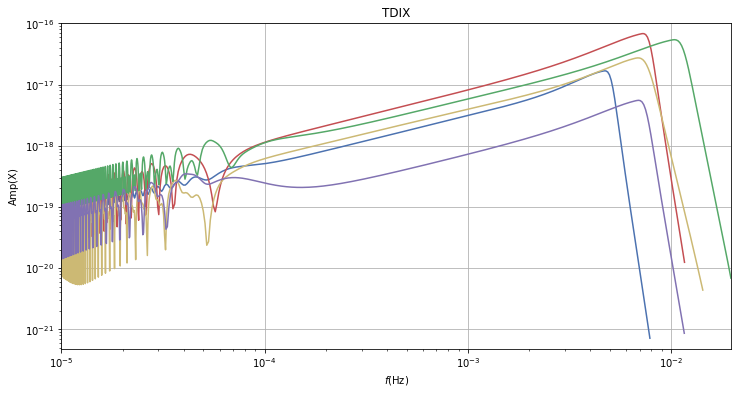

In [19]:
f, ax = plt.subplots(1, 1, figsize=[12,6])
lloglogplot(ax, *[[wfTDI['freq'], wfTDI['amp']*np.abs(wfTDI['transferL1'])] for wfTDI in wfTDIlist])
ax.set_xlabel(r'$f({\rm Hz})$')
ax.set_ylabel(r'${\rm Amp}({\rm X})$')
ax.set_title(r'TDIX')

### Generate catalog dataset

In [20]:
maxfsignal = max([wfTDI['freq'][-1] for wfTDI in wfTDIlist])
maxfsignal

0.019696498545627234

In [21]:
1./2/maxfsignal

25.385222598917391

In [22]:
dt_SMBH = 30.
fsample_SMBH = 1./dt_SMBH
fnyquist_SMBH = 1./2*fsample_SMBH
[fsample_SMBH, dt_SMBH]

[0.03333333333333333, 30.0]

In [23]:
max([Tcs[ind]/YRSID_SI for ind in inds])

1.0126385811412535

In [24]:
T_SMBH = 1.2*YRSID_SI
df_SMBH = 1./2/T_SMBH
df_SMBH

1.3203139911199078e-08

In [25]:
n_SMBH = int(fnyquist_SMBH/df_SMBH)+1
n_SMBH

1262326

In [26]:
freqs_SMBH = df_SMBH*np.arange(n_SMBH)
freqs_SMBH = freqs_SMBH[(freqs_SMBH>=minf) & (freqs_SMBH<=maxf)]
print len(freqs_SMBH)
[freqs_SMBH[0], freqs_SMBH[-1]]

1261568


[1.0007980052688902e-05, 0.016666653588404377]

In [27]:
# Computing given TDI channel by interpolation
def func_evaluate_wfTDI(freqs, wfTDI, chan=1):
    res = np.zeros(len(freqs), dtype=complex)
    fbeg = max(freqs[0], wfTDI['freq'][0])
    fend = min(freqs[-1], wfTDI['freq'][-1])
    ibeg = np.where(freqs>=fbeg)[0][0]
    iend = np.where(freqs<=fend)[0][-1]
    fs = freqs[ibeg:iend+1]
    t0 = wfTDI['t0'] # will be used to apply timeshift
    ampspline = spline(wfTDI['freq'], wfTDI['amp'])
    phasespline = spline(wfTDI['freq'], wfTDI['phase'])
    phaseRdelayspline = spline(wfTDI['freq'], wfTDI['phaseRdelay'])
    keytransfer = 'transferL'+str(chan)
    transferLRespline = spline(wfTDI['freq'], np.real(wfTDI[keytransfer]))
    transferLImspline = spline(wfTDI['freq'], np.imag(wfTDI[keytransfer]))
    amp = ampspline(fs)
    phase = phasespline(fs)
    phaseRdelay = phaseRdelayspline(fs)
    transferLRe = transferLRespline(fs)
    transferLIm = transferLImspline(fs)
    phasetimeshift = 2*pi*t0*fs
    vals = (transferLRe+1j*transferLIm) * amp * np.exp(1j*(phase+phaseRdelay+phasetimeshift))
    res[ibeg:iend+1] = vals
    return res

In [28]:
wfTDIXdatalist = []
for wfTDI in wfTDIlist:
    wfTDIXdatalist = wfTDIXdatalist + [func_evaluate_wfTDI(freqs_SMBH, wfTDI, chan=1)]

In [29]:
wfTDIXdataset = np.zeros(len(wfTDIXdatalist[0]), dtype=complex)
for wfTDIXdata in wfTDIXdatalist:
    wfTDIXdataset += wfTDIXdata

Text(0.5,1,u'TDIX Dataset (superposed sources)')

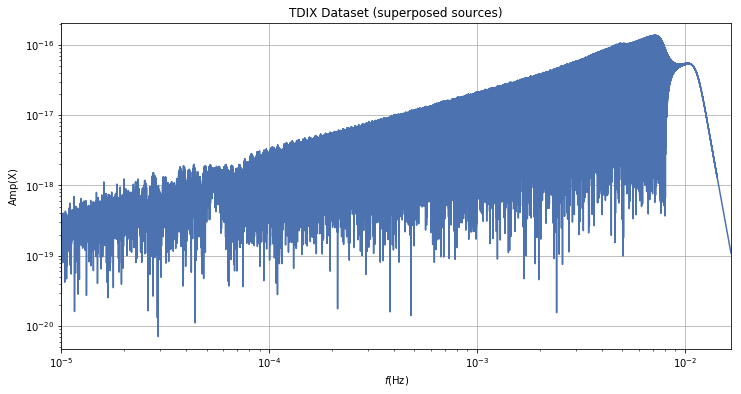

In [30]:
f, ax = plt.subplots(1, 1, figsize=[12,6])
lloglogplot(ax, [freqs_SMBH, np.abs(wfTDIXdataset)])
ax.set_xlabel(r'$f({\rm Hz})$')
ax.set_ylabel(r'${\rm Amp}({\rm X})$')
ax.set_title(r'TDIX Dataset (superposed sources)')

## SOBH

### Read and select catalogue

In [20]:
# Format: 1 source_nb z DL(Gpc) redshifted_m1(Msol) redshifted_m2(Msol) fstart(Hz) fend(Hz) Deltat_coalescence(yr) Thetasky Phisky inclination polarization |chi1| |chi2| theta(chi1,L) theta(chi2,L) theta(chi1perp,chi2perp) angle? approx_amp SNR
SOBHcatAll = np.loadtxt("../../../../../Catalogues/SOBHs/GOAT_SRC_SNR1_MF101_NMC101.OUT")
len(SOBHcatAll)

21721

In [32]:
#np.savetxt('SOBHcatShort.txt', SOBHcatAll[:100])

In [21]:
LL = 2.5e9
Reff = 2./pi*R_SI
Omega0 = 2*pi/YRSID_SI
def funcestimateforfomorb2nd1(f):
    return (2*pi*f*Reff/C_SI*Omega0**2)
def funcestimateforfomorb2nd2(f):
    return (2*pi*f*Reff/C_SI*Omega0)**2
def funcestimateforfomorb2nd(f):
    return max(funcestimateforfomorb2nd1(f), funcestimateforfomorb2nd2(f))
def funcestimateforfomconst2nd1(f):
    return (4*pi*f*LL/C_SI*Omega0**2)
def funcestimateforfomconst2nd2(f):
    return (4*pi*f**2*(LL/C_SI)**2*Omega0**2)
def funcestimateforfomconst2nd3(f):
    return Omega0**2
def funcestimateforfomconst2nd(f): 
    return max(funcestimateforfomconst2nd1(f), funcestimateforfomconst2nd2(f), funcestimateforfomconst2nd3(f))

def funcFOMApprox(key, m1, m2, fstart):
    M = m1 + m2
    q = max(m1/m2, m2/m1)
    nu = q/(1+q)**2
    Msec = M*MTSUN_SI
    def Tffunc(f):
        return 1./8*sqrt(5./(3*nu))*Msec*(pi*Msec*f)**(-11./6)
    if key=='Psiorb':
        fom = 1./2*Tffunc(fstart)**2*funcestimateforfomorb2nd(fstart)
    elif key=='Psiconst':
        fom = 1./2*Tffunc(fstart)**2*funcestimateforfomconst2nd(fstart)
    return fom

In [30]:
# We select only the sources that are chirping enough, having an error measure for the phase correction terms <1. (when >1 this quantity indicates a breakdown of the perturbative treatment)
fomvalsAll = np.array(map(lambda x: funcFOMApprox('Psiorb', x[4], x[5], x[6]), SOBHcatAll))
SOBHcatPert = SOBHcatAll[fomvalsAll<=1.]
fomvalsPert = fomvalsAll[fomvalsAll<=1.]
SOBHcatComb = SOBHcatAll[fomvalsAll>1.]
fomvalsComb = fomvalsAll[fomvalsAll>1.]
print "Length of full catalogue: ", len(SOBHcatAll), ", worst error measure: ", max(fomvalsAll)
print "Length of catalogue FOM<1 (perturbative approach): ", len(SOBHcatPert), ", worst error measure: ", max(fomvalsPert)
print "Length of catalogue FOM>1 (comb approach): ", len(SOBHcatComb), ", worst error measure: ", max(fomvalsComb)

Length of full catalogue:  21721 , worst error measure:  14.826199310346322
Length of catalogue FOM<1 (perturbative approach):  20076 , worst error measure:  0.9996998772628377
Length of catalogue FOM>1 (comb approach):  1645 , worst error measure:  14.826199310346322


In [33]:
SOBHcatSNR8 = SOBHcatAll[SOBHcatAll[:,-1]>=8.]
fomvalsSNR8 = np.array(map(lambda x: funcFOMApprox('Psiorb', x[4], x[5], x[6]), SOBHcatSNR8))
print "Length of catalogue SNR>8: ", len(SOBHcatSNR8), ", worst error measure: ", max(fomvalsSNR8)
print "Length of catalogue SNR>8 FOM<1 (perturbative approach): ", len(fomvalsSNR8[fomvalsSNR8<=1.]), ", worst error measure: ", max(fomvalsSNR8[fomvalsSNR8<=1.])
print "Length of catalogue SNR>8 FOM>1 (comb approach): ", len(fomvalsSNR8[fomvalsSNR8>1.]), ", worst error measure: ", max(fomvalsSNR8[fomvalsSNR8>1.])

Length of catalogue SNR>8:  82 , worst error measure:  6.056035164226638
Length of catalogue SNR>8 FOM<1 (perturbative approach):  78 , worst error measure:  0.927042670561341
Length of catalogue SNR>8 FOM>1 (comb approach):  4 , worst error measure:  6.056035164226638


### For this example, we only generate a subset of waveforms

In [39]:
# Generate only 400 out of ~20000 waveforms
SOBHcatEvaluate = SOBHcatAll[:400]

### Generate individual waveforms

In [40]:
nSOBH = len(SOBHcatEvaluate)
phi0s_SOBH = np.random.uniform(0.0, 2.0*np.pi, size=nSOBH)

In [41]:
# So far, the only choice implemented: MLDC trajectories and TDI XYZ
[fRef, trajdict, TDItag] = [0., trajdict_MLDC, "TDIXYZ"]

In [44]:
wfTDIlist_SOBH = []
t1 = time.time()
for i, p in enumerate(SOBHcatEvaluate):
    if i%100==0:
        print str(i)+'/'+str(len(SOBHcatEvaluate))
    
    # Format: 1 source_nb z DL(Gpc) redshifted_m1(Msol) redshifted_m2(Msol) fstart(Hz) fend(Hz) Deltat_coalescence(yr) Thetasky Phisky inclination polarization |chi1| |chi2| theta(chi1,L) theta(chi2,L) theta(chi1perp,chi2perp) angle? approx_amp SNR
    fstart, fend = [p[6], p[7]]
    m1, m2, DL, lambd, beta, inc, pol = [p[4], p[5], 1e3*p[3], p[10], pi/2-p[9], p[11], p[12]]
    chi1, chi2, thetachi1, thetachi2 = [p[13], p[14], p[15], p[16]]
    
    a1 = np.cos(thetachi1)*chi1
    a2 = np.cos(thetachi2)*chi2
    if (m2>m1):
        m_tmp = m1
        m1 = m2
        m2 = m_tmp
    q = m1/m2
    eta = m1*m2/(m1+m2)**2
    
    # Random params (not in catalogue)
    phi0 = phi0s_SOBH[i]

    # Duration of observation ~4years for this catalogue, frequency band from 1e-5Hz to 0.1Hz - will be limited by observation time
    # t0 is the time of merger, tobs the duration of observation
    # Set tobs=0. to ignore it - we will start at fstart
    [minf, maxf, tobs, t0] = [1e-5, 1e-1, 0., 0.]
    [fRef, tRef] = [fstart, 0.] # Set t=0 at the starting frequency
    
    # Evaluate error measure and adjust the stencil order accordingly
    fom = funcFOMApprox('Psiorb', p[4], p[5], p[6])
    if fom>1.:
        # Generate waveform using comb approach
        wfTDIlist_SOBH = wfTDIlist_SOBH + [LISAGenerateCombTDI(phi0, fRef, m1, m2, a1, a2, DL, inc, lambd, beta, pol, tobs=tobs, minf=max(minf, fstart), maxf=min(maxf, fend), t0=t0, settRefAtfRef=True, tRef=tRef, trajdict=trajdict_MLDC, TDItag='TDIXYZ', nptmin=400)]
    else: # pert approach
        if fom<0.1:
            order = 3
        elif fom<0.2:
            order = 5
        elif fom<0.5:
            order=10
        else:
            order=20
        # Generate waveform using pert approach
        wfTDIlist_SOBH = wfTDIlist_SOBH + [LISAGenerateTDI(phi0, fRef, m1, m2, a1, a2, DL, inc, lambd, beta, pol, tobs=tobs, minf=max(minf, fstart), maxf=min(maxf, fend), t0=t0, settRefAtfRef=True, tRef=tRef, trajdict=trajdict_MLDC, TDItag='TDIXYZ', nptmin=400, order_fresnel_stencil=order)]
t2 = time.time()
print "Av. time/waveform (s): ", (t2-t1)/len(wfTDIlist_SOBH)

0/400
100/400
200/400
300/400
Av. time/waveform (s):  0.234382910132


In [45]:
map(lambda x: len(x['freq']), wfTDIlist_SOBH)

[401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 402,
 401,
 401,
 401,
 402,
 401,
 401,
 402,
 401,
 401,
 401,
 401,
 401,
 402,
 401,
 401,
 402,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 402,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 402,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 404,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 402,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 402,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 401,
 402

In [46]:
print "Flag for presence of nans in the waveforms: ", np.any([np.any([np.any(np.isnan(wf[k])) for k in wf.keys() if not k=='TDItag']) for wf in wfTDIlist_SOBH])

Flag for presence of nans in the waveforms:  False


### Generate catalog dataset

In [47]:
maxfsignal = 0.1

In [48]:
1./2/maxfsignal

5.0

In [49]:
dt_SOBH = 5.
fsample_SOBH = 1./dt_SOBH
fnyquist_SOBH = 1./2*fsample_SOBH
[fsample_SOBH, dt_SOBH]

[0.2, 5.0]

In [50]:
# [fstart, fend] in the catalogue correspond to ~4years (not exactly, so we take some margin)
T_SOBH = 4.5*YRSID_SI
df_SOBH = 1./2/T_SOBH
df_SOBH

3.5208373096530877e-09

In [51]:
n_SOBH = int(fnyquist_SOBH/df_SOBH)+1
n_SOBH

28402335

In [52]:
freqs_SOBH = df_SOBH*np.arange(n_SOBH)
freqs_SOBH = freqs_SOBH[(freqs_SOBH>=1e-4) & (freqs_SOBH<=1e-1)]
print "Total number of frequency samples: ", len(freqs_SOBH)
print "Frequency band covered: ", [freqs_SOBH[0], freqs_SOBH[-1]]

Total number of frequency samples:  28373932
Frequency band covered:  [0.00010000234210607664, 0.09999999722842842]


In [53]:
# Getting nb of freq samples needed to interpolate on
# NOTE: assumes constant deltaf
def func_nbsamples_wfTDI(freqs, wfTDI):
    df = freqs[1] - freqs[0]
    fbeg = max(freqs[0], wfTDI['freq'][0])
    fend = min(freqs[-1], wfTDI['freq'][-1])
    ibeg = int((fbeg - freqs[0])/df) + 1
    iend = int((fend - freqs[0])/df)
    return iend-ibeg+1

In [54]:
wfTDIXdatalength = []
for wfTDI in wfTDIlist_SOBH:
    wfTDIXdatalength = wfTDIXdatalength + [func_nbsamples_wfTDI(freqs_SOBH, wfTDI)]

In [55]:
wfTDIXdatalength

[91171,
 514082,
 95744,
 19594769,
 614911,
 35475,
 129174,
 369230,
 570632,
 138916,
 74158,
 5255,
 63139,
 53652,
 67570,
 57685,
 29425,
 393912,
 9742,
 8804,
 1787643,
 386300,
 118949,
 317936,
 71460,
 13917,
 286011,
 20336,
 585372,
 59701,
 47971,
 62996,
 24895497,
 76260,
 96426,
 2181300,
 871099,
 14485,
 172970,
 192170,
 94722,
 3323,
 3578,
 25477,
 86712,
 51578,
 539076,
 93983,
 38514,
 438958,
 275076,
 26982,
 32776,
 44421,
 46041,
 22363145,
 23658860,
 61377,
 8691,
 19894130,
 48085,
 8066,
 402745,
 53510,
 272435,
 44734,
 13690,
 232303,
 39252,
 124602,
 128861,
 692449,
 59418,
 1121324,
 18490,
 33458,
 67938,
 37633,
 13207,
 2213110,
 1242602,
 71148,
 882176,
 3834,
 455573,
 31043,
 1128907,
 1591383,
 482783,
 45785,
 25704,
 351592,
 33430,
 2010033,
 8748,
 4345,
 1960,
 23253558,
 1004874,
 85974,
 30191,
 16957,
 14656,
 25281769,
 26443,
 19228,
 1124164,
 20691668,
 3380162,
 25306,
 254201,
 25875,
 15138,
 13832,
 1214768,
 73619,
 19910

In [56]:
# Computing given TDI channel by interpolation
# NOTE: assumes constant deltaf
def func_evaluate_wfTDI_addtodataset(freqs, dataset, wfTDI, chan=1):
    df = freqs[1] - freqs[0]
    fbeg = max(freqs[0], wfTDI['freq'][0])
    fend = min(freqs[-1], wfTDI['freq'][-1])
    ibeg = int((fbeg - freqs[0])/df) + 1
    iend = int((fend - freqs[0])/df)
    fs = freqs[ibeg:iend+1]
    t0 = wfTDI['t0'] # will be used to apply timeshift
    ampspline = spline(wfTDI['freq'], wfTDI['amp'])
    phasespline = spline(wfTDI['freq'], wfTDI['phase'])
    phaseRdelayspline = spline(wfTDI['freq'], wfTDI['phaseRdelay'])
    keytransfer = 'transferL'+str(chan)
    transferLRespline = spline(wfTDI['freq'], np.real(wfTDI[keytransfer]))
    transferLImspline = spline(wfTDI['freq'], np.imag(wfTDI[keytransfer]))
    amp = ampspline(fs)
    phase = phasespline(fs)
    phaseRdelay = phaseRdelayspline(fs)
    transferLRe = transferLRespline(fs)
    transferLIm = transferLImspline(fs)
    phasetimeshift = 2*pi*t0*fs
    vals = (transferLRe+1j*transferLIm) * amp * np.exp(1j*(phase+phaseRdelay+phasetimeshift))
    dataset[ibeg:iend+1] += vals

In [57]:
t1 = time.time()
wfTDIXdataset = np.zeros(len(freqs_SOBH), dtype=complex)
for i, wfTDI in enumerate(wfTDIlist_SOBH):
    if i%20==0:
        print str(i)+'/'+str(len(wfTDIlist_SOBH))
    func_evaluate_wfTDI_addtodataset(freqs_SOBH, wfTDIXdataset, wfTDI, chan=1)
t2 = time.time()
print "Av. time/waveform (s): ",  (t2-t1)/len(wfTDIlist_SOBH)

0/400
20/400
40/400
60/400
80/400
100/400
120/400
140/400
160/400
180/400
200/400
220/400
240/400
260/400
280/400
300/400
320/400
340/400
360/400
380/400
Av. time/waveform (s):  0.61650765717


In [58]:
print "Length of output dataset: ", len(wfTDIXdataset)
print "Flag for presence of nans in the output dataset: ", np.any(np.isnan(wfTDIXdataset))

Length of output dataset:  28373932
Flag for presence of nans in the output dataset:  False


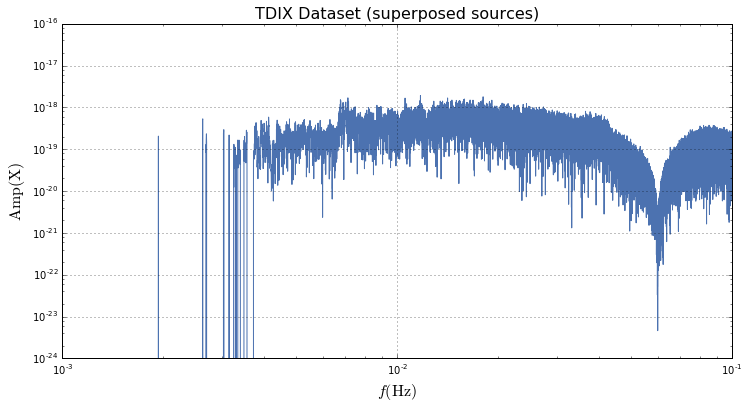

In [61]:
f, ax = plt.subplots(1, 1, figsize=[12,6])
lloglogplot(ax, [freqs_SOBH[::1000], np.abs(wfTDIXdataset[::1000])], rangex=[1e-3, 1e-1], rangey=[1e-24, 1e-16])
ax.set_xlabel(r'$f({\rm Hz})$', fontsize=16)
ax.set_ylabel(r'${\rm Amp}({\rm X})$', fontsize=16)
ax.set_title(r'TDIX Dataset (superposed sources)', fontsize=16)

In [56]:
# Beware: large file to output !
wfTDIXdataset.tofile('test_TDIXdataset.dat')